![X-Ray - Image CC0 - pexels.com](./img/pexels-anna-shvets-4226258.jpg)

Chest X-Ray encoder (CXRE)
==========================

Levi-dan Azoulay  
Nathane Berrebi  
Ali Bellamine

# Description

>

# Project

# Downloading data

We work in a randomly picked sample of 2% the [MIMIC-IV-CXR database](https://physionet.org/content/mimic-cxr/2.0.0/).
We based our worked on a derivated database name [MIMIC-CXR-JPG](https://physionet.org/content/mimic-cxr-jpg/2.0.0/) in order to work from a homogenized way to transform DICOM images to JPG and to perform features extraction from report notes.

We will work with JPG images instead of DICOM raw images mainly because of our harware limitation in disk storage.

The download script is available for any review in `./download_mimic.py` but for conveniency we will directly provide the processed data.

In [3]:
import download_data

# Download the data
## Fill the token

token = "" # Fill the current line

#download_data.download_data(token=token, folder="./data") # Uncomment this line to download data

# Loading data

The downloaded data are available in the `./data` folder.  
It contains somes CSV files containing the `MIMIC-IV` image's metadata and annotations, image's report and images in a JPG format.  

To work easily with the image, we provided a `Dataset` class which abstract the dataloading and a `get_data` function which concatenate the metadata from CSV files and provide an X and y dataset.

In [4]:
from utils.preprocessing import get_data
from matplotlib import pyplot as plt

X, y, X_annotated, y_annotated = get_data("./data", annotations_path="./data/annotations_08032021.zip", split_annotation=True)

## Images and images' metadata

The get_data function return a tuple X and y, X is a tuple containing the images' Dataset and metadata, y contains the labels.

The images are Chest Radiographie.  
There is a wide heterogeneity in this kind of images, we can distinguish :
- Frontal chest Classical X-Ray
- Lateral chest Classical X-Ray
- Frontal chest Portable X-Ray
- Lateral chest Portable X-Ray
- Frontal X-Ray in lying position

Indeed, a good quality radiography should be performed in a standing position, but when it is not possible it is done in a lying position, which gives a totally different image.  
Let's look at somes images.

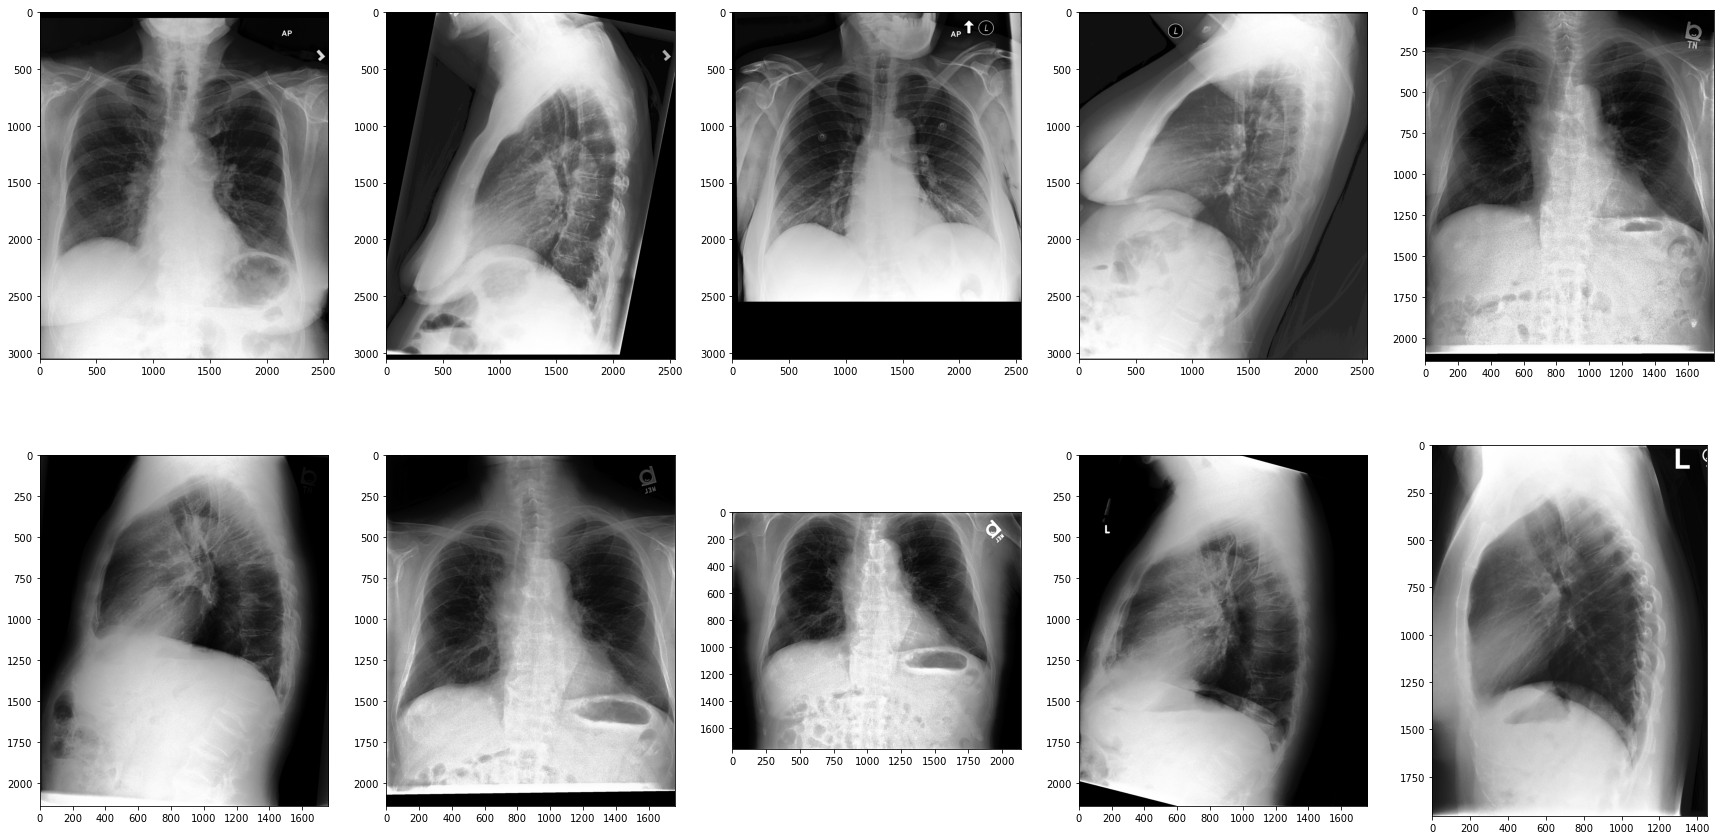

In [5]:
fig, axs = plt.subplots(2,5, figsize=(30,15))
axs = axs.flatten()

for i in range(10):
    image = X[0][i][0]
    axs[i].imshow(image, cmap="gray")

The images metadata contains the image size, the position of the patient during the acquisition and the kind of acquisition (classifical or portable).  
In a first time, we will not use this information and focus in the image to explore somes Deep Learning method.

In [6]:
X[1].head(5)

,uid,dicom_id,subject_id,study_id,PerformedProcedureStepDescription,ViewPosition,Rows,Columns,StudyDate,StudyTime,ProcedureCodeSequence_CodeMeaning,ViewCodeSequence_CodeMeaning,PatientOrientationCodeSequence_CodeMeaning
0,0,19e55bee-714bb193-0968d683-5bf655a5-7b5caba9,10001401,58747570,CHEST (PA AND LAT),PA,3056,2544,21310730,134837.843,CHEST (PA AND LAT),postero-anterior,Erect
1,1,f56a3d51-284b2466-262661f1-2567a6ab-248f4ae3,10001401,58747570,CHEST (PA AND LAT),LATERAL,3056,2544,21310730,134837.843,CHEST (PA AND LAT),lateral,Erect
2,2,84c6ecc4-fd81e31d-1e879d18-13024211-35de54ad,10002930,55885481,CHEST (PA AND LAT),AP,3056,2544,21980417,152156.609,CHEST (PA AND LAT),antero-posterior,Erect
3,3,eb71d6af-79edf48e-4fecee5b-133fa0e2-614d733f,10002930,55885481,CHEST (PA AND LAT),LATERAL,3056,2544,21980417,152156.609,CHEST (PA AND LAT),lateral,Erect
4,4,291d51fa-d786f2a5-7519f2fa-409c3d4a-6465003c,10003019,52117631,CHEST (PA AND LAT),NaN,2140,1760,21750704,105319.000,CHEST (PA AND LAT),NaN,NaN


## Labels

The label dataframe contains :
- Image reports / Segmented image report
- MIMIC-CXR-JPG images labels
- Our custom labels

### Images reports

Each image is associated with a `study_id`. This id is an unique examination id containing one or more images.  
For each `study_id` is provided an unique examination report that we stored in the `y` Dataframe.  
We can see, and verify, that the report are well structured.

In [7]:
# An example of report
print(y["report"][10])

                                 FINAL REPORT
 INDICATION:  Cough for one year.
 
 No comparison studies available.
 
 FRONTAL AND LATERAL CHEST RADIOGRAPHS:  The heart size is normal.  The hilar
 and mediastinal contours are within normal limits.  There is no pneumothorax,
 focal consolidation, or pleural effusion.
 
 IMPRESSION:  Normal chest radiograph.



Thus, we provided in the `get_data` function some basic regex text segmentation in the following columns :

In [8]:
reports_columns = [x for x in y.columns if x.startswith("report_")]
print(reports_columns)

['report_extra', 'report_comparison', 'report_findings', 'report_impression', 'report_indication', 'report_reason_for_exam', 'report_reason_for_examination']


### MIMIC-CXR-JPG images labels

The MIMIC-CXR-JPG database provide some labels about the main disease in the image, these are stored in the `y` Dataframe.  
A 1 is expected when a disease is described, -1 when its presence is ambigeous.

In [9]:
labels = y.columns[3:17].tolist()
y[labels].sum().astype("int")

Atelectasis                    881
Cardiomegaly                   932
Consolidation                  126
Edema                          299
Enlarged Cardiomediastinum     -32
Fracture                       100
Lung Lesion                    186
Lung Opacity                  1177
No Finding                    2537
Pleural Effusion              1184
Pleural Other                   39
Pneumonia                      -16
Pneumothorax                   200
Support Devices               1482
dtype: int32

These labels are provided given a Natural Langage Processing algorithm. We explored whether these were reliable by reading some documents and noticed that the negation detection was no accurate.  
Here is a well chosen examples :

In [10]:
print(
    y.loc[250, "report"]
)
tmp_labels = y.loc[250, "text_label"]
print(f"Labels : {tmp_labels}")
# A pneumothorax is detected even is it written "no pneumothorax"

                                 FINAL REPORT
 PORTABLE CHEST FILM, ___ AT 11:41
 
 CLINICAL INDICATION:  ___-year-old with bifrontal glioblastoma and seizures
 with possible UTI, question pneumonia.
 
 Comparison to ___ at ___.
 
 AP portable supine chest film, ___ at 11:41 is submitted.
 
 IMPRESSION:
 
 Right-sided Port-A-Cath remains in place with tip in the distal SVC.  Overall
 cardiac and mediastinal contours are unchanged.  Linear opacity at the left
 base most likely reflects subsegmental atelectasis or scarring.  No focal
 airspace consolidation seen to suggest pneumonia.  No pleural effusions or
 pulmonary edema.  No pneumothorax, although the sensitivity to detect
 pneumothorax is diminished given supine technique.

Labels : Atelectasis,Enlarged Cardiomediastinum,Lung Opacity,Pneumothorax


### Our custom labels

We thus decided to annotate the dataset in order to get reliable labels.  
We performed somes annotations according to the images' report using an instance of `doccano` annotation tool.  
Theses annotations are integrated in the `y` by the `get_data` function. We added a parameter to separate the images with and without annotations.  
Thus, all the annotations are stored in the `y_annotated` dataframe.  
We annotated a total of 560 reports which correspond to 932 imahes.

In [11]:
custom_labels = [x for x in y_annotated.columns if x.startswith("annotation")]
y_annotated[custom_labels].sum().astype("int")

annotation_Cardiomégalie                   169
annotation_Oedeme pulmonaire               120
annotation_Epanchement pleural             202
annotation_Atelectasie                     196
annotation_Surveillance matériel           269
annotation_Autres                          102
annotation_Pneumothorax                     24
annotation_Infection respiratoire basse     78
annotation_Normal                          365
dtype: int32

Let's confirm our insight about the NLP-based labels :

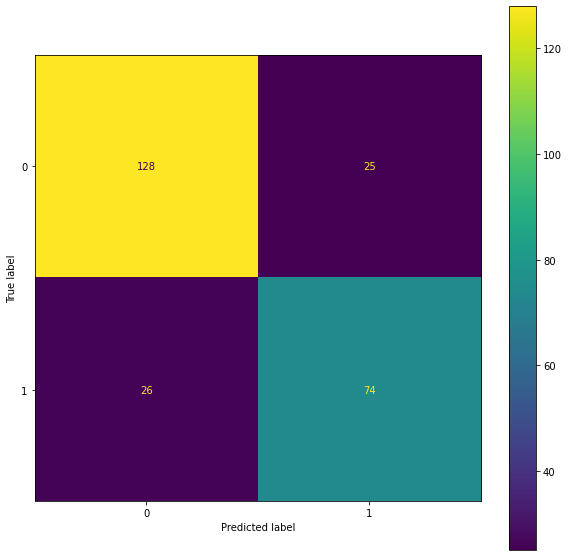

In [12]:
# Example on Edema : Left = NLP based label, Right = Custom annotation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
new_label = "annotation_Oedeme pulmonaire"
old_label = "Edema"
tmp_y_annotated = y_annotated[[new_label, old_label]].dropna()

fix, ax = plt.subplots(1,1, figsize=(10,10))
ConfusionMatrixDisplay(
    confusion_matrix(
        tmp_y_annotated[new_label], 
        tmp_y_annotated[old_label].replace(-1, 0)
    )
).plot(ax=ax)
plt.show()

# Auto-encoder

We train two auto-encoder network :
- 1. Image auto-encoder (**CXR_AE_1**)
- 2. Image + embedding auto-encoder (**CXR_AE_2**)

The first be based on a Conv-Deconv architecture with an **image reconstruction** loss function based on a **mean square error**.  
The second will be the same as the first, but we will also try to reconstruct the embeddings of the **Impressions** and **Findings** subpart of the report from the latent space.

The main idea behind this is to force the auto-encoder to focus on **clinical** relevant information.
The documents embeddings will be produced according to the `bert-base-uncased` from the `Huggingface` implementation.  
We choosed to work with a `BERT` model because we need to get a contextual embedding to increase the ability of the system to distringuish between relevant and non relevant information. We choosed the `uncased` because we did not notice an importance of the Case during our annotation.

The auto-encoder will be only trained on non-annotated data.

[INSERER SCHEMA]

In [13]:
import importlib
from utils import autoencoders
from utils import autoencoders_unet
from utils.text_processing import bert

importlib.reload(autoencoders)
importlib.reload(autoencoders_unet)
importlib.reload(bert)

<module 'utils.text_processing.bert' from 'c:\\Users\\4078182\\Personal\\git\\mimic_cxr_clustering\\utils\\text_processing\\bert.py'>

In [14]:
import os
import torch
import numpy as np
from utils.autoencoders import cxr_ae_1, cxr_ae_2
from utils.autoencoders_unet import cxr_unet_ae_1, cxr_unet_ae_2
from utils.image_processing import get_collater, preprocess_image, numpy_to_tensor, tensor_to_numpy
from utils.training import train_model
from utils.text_processing.base import get_documents_embeddings
from utils.text_processing.bert import BertEmbedder

visual_check_id = np.random.choice(range(len(X[0])), 3)

## Training CXR_AE_1

In [15]:
model_path = "./models/cxr_ae_1_unet_v1.model"
cxr_ae_1_unet_model = cxr_unet_ae_1(noise_variance=1e-4)

if os.path.exists(model_path):
    cxr_ae_1_unet_model.load_model(model_path)

In [113]:
train_model(
    cxr_ae_1_unet_model,
    X=X[0],
    y=None,
    n_epoch=5,
    batch_size=4,
    collater_fn_x=get_collater(size=256, crop=True, rotate=True),
    collater_fn_y=None,
    use_gpu_if_available=True,
    loss_names=["Reconstruction loss"]
)

Epoch 4: 100%|██████████| 1643/1643 [07:42<00:00,  3.55batch/s, Mean Reconstruction loss=0.0616, Reconstruction loss=0.0478]


In [114]:
cxr_ae_1_unet_model.save_model(model_path)

## Training CXR_AE_2

In [16]:
model_path = "./models/cxr_ae_2_unet_v1.model"
cxr_ae_2_unet_model = cxr_unet_ae_2(embedding_size=768)

if os.path.exists(model_path):
    cxr_ae_2_unet_model.load_model(model_path)

In [35]:
bert_embedder = BertEmbedder(preprocessing=False, batch_size=128, use_gpu_if_available=True)
#y_embeddings = tuple([torch.tensor(get_documents_embeddings(y, bert_embedder, column), dtype=torch.float32) for column in ["report_findings", "report_impression"]])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [47]:
train_model(
    cxr_ae_2_unet_model,
    X=X[0],
    y=y_embeddings[1],
    n_epoch=20,
    batch_size=4,
    collater_fn_x=get_collater(size=256, crop=True, rotate=True),
    collater_fn_y=None,
    use_gpu_if_available=True,
    loss_names=["Reconstruction loss", "Embedding Loss"],
)

Epoch 19: 100%|██████████| 1643/1643 [07:37<00:00,  3.59batch/s, Embedding Loss=0.0298, Mean Embedding Loss=0.0266, Mean Reconstruction loss=0.0566, Reconstruction loss=0.0488] 


In [52]:
cxr_ae_2_unet_model.save_model(model_path)

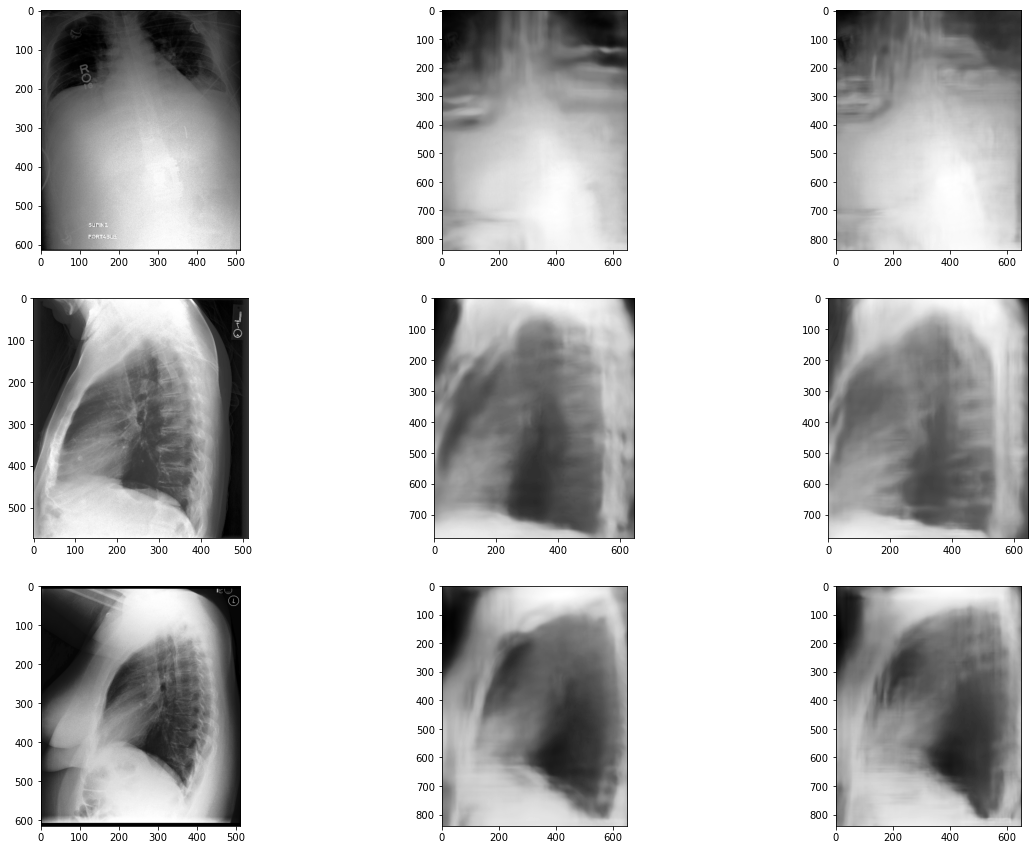

In [61]:
# Somes images, their latent space and re-construction
with torch.no_grad():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model1 = cxr_ae_1_unet_model.to(device)
    model2 = cxr_ae_2_unet_model.to(device)

    fig, axs = plt.subplots(3, len(visual_check_id), figsize=(20,15))

    for i in range(len(visual_check_id)):
        image = X[0][[visual_check_id[i]]][0]
        preprocessed_image = preprocess_image(numpy_to_tensor(image), size=512).to(device)
        decoded_image_ae1 = model1.predict(preprocessed_image.unsqueeze(0))
        decoded_image_ae2, _ = model2.predict(preprocessed_image.unsqueeze(0), embedding=False)

        axs[i][0].imshow(tensor_to_numpy(preprocessed_image), cmap="gray")
        axs[i][1].imshow(tensor_to_numpy(decoded_image_ae1), cmap="gray")
        axs[i][2].imshow(tensor_to_numpy(decoded_image_ae2), cmap="gray")

# Images classification

We provide and compare 3 images classification algorithms :
- 1. Classifier from images without auto-encoder (**CLASS_NAIVE**)
- 2. Classifier from images with the CXR_AE_1 auto-encoder (**CLASS_CXR_AE_1**)
- 3. Classifier from images with the CXR_AE_2 auto-encoder (**CLASS_CXR_AE_2**)

The main metrics are :
- Accuracy
- F1-Score
- Area under the curve (AUC)
- Precision
- Recall

We decided to use multiple metrics due to the 

## Train-Test splitting

In [19]:
from sklearn.model_selection import train_test_split

To prevent data-leakage, the train-test split is done according to the `study_id`.
Because we want to benchmark the performances in order to evaluate the auto-encoder strategy, we will drop lateral radiography for simplicity reason. 

In [20]:
study_id_train, study_id_test = train_test_split(X_annotated[1]["study_id"].unique(), test_size=0.2, random_state=42)
labels = [x for x in y_annotated.columns if x.startswith("annotation")]

In [21]:
# Getting train and test uids
uid_train = X_annotated[1][X_annotated[1]["study_id"].isin(study_id_train)].query("ViewPosition.isin(['AP','PA'])", engine="python")["uid"].values.tolist()
uid_test = X_annotated[1][X_annotated[1]["study_id"].isin(study_id_train) == False].query("ViewPosition.isin(['AP','PA'])", engine="python")["uid"].values.tolist()

X_train = X_annotated[0].split(uid_list=uid_train)[0]
y_train = y_annotated.set_index("uid").loc[uid_train, labels]
X_test = X_annotated[0].split(uid_list=uid_test)[0]
y_test = y_annotated.set_index("uid").loc[uid_test, labels]

## Training CLASS_NAIVE

In [22]:
from torch import nn, optim
from torchvision.models import mobilenet_v3_small
from utils.training import train_model, get_prediction
from utils.image_processing import get_collater, preprocess_image, numpy_to_tensor, tensor_to_numpy

import torch

class imageClassifier (nn.Module):
    def __init__ (self, n_labels=9, weight_balance=True, weights=None):
        super().__init__()

       # Getting backbone
        self.mobilenet = mobilenet_v3_small(pretrained=True)
        self.weight_balance = weight_balance
        self.weights = weights

        # Layer that duplicate the color layer (b&w to rgb)
        duplicate_color_layers = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=(1,1), padding="same")
        duplicate_color_layers.requires_grad_(False)
        duplicate_color_layers.load_state_dict({
            "weight":torch.ones(duplicate_color_layers.weight.shape, dtype=torch.float32),
            "bias":torch.zeros(duplicate_color_layers.bias.shape)
        })

        self.encoder = nn.Sequential(*[
            duplicate_color_layers,
            nn.Sequential(*list(self.mobilenet.features.children()))[0:-3],
            nn.Conv2d(96, 48, (3,3), padding="same"),
            nn.BatchNorm2d(48),
            nn.ReLU(),
            nn.Conv2d(48, 24, (3,3), padding="same")
        ])

        self.classification_layer = nn.Sequential(
            nn.Conv2d(24, 48, (3,3), padding="same"),
            nn.BatchNorm2d(48),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Conv2d(48, 96, (3,3)),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.Conv2d(96, 256, (3,3)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((2,2)),
            nn.Flatten(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 32),
            nn.ReLU(),
            nn.Linear(32, n_labels),
            nn.Sigmoid()
        )

        self.loss_fn = nn.BCELoss()
        self.optimizer = optim.Adam(self.parameters(), lr=1e-4)

    def forward (self, x):
        y_hat = self.encoder(x)
        y_hat = self.classification_layer(y_hat)

        return y_hat

    def predict_proba (self, x):
        self.eval()

        if isinstance(x, list):
            x = x[0]

        with torch.no_grad():
            y_hat = self.forward(x)

            return y_hat.cpu().numpy()

    def predict (self, x):

        if isinstance(x, list):
            x = x[0]

        y_hat = self.predict_proba(x)

        return (y_hat >= 0.5)*1

    def fit (self, x, y):

        if self.weight_balance and self.weights is not None:
            self.loss_fn.weight = y*self.weights[1,:] + (1-y)*self.weights[0,:]

        self.train()
        self.optimizer.zero_grad()

        y_hat = self.forward(x)
        loss = self.loss_fn(y_hat, y)

        loss.backward()

        self.optimizer.step()

        loss_scalar = loss.detach().cpu().item()
        return [loss_scalar]

In [23]:
from sklearn.utils.class_weight import compute_class_weight

In [24]:
y_train_filtered = y_train.values
weights = []
for i in range(y_train_filtered.shape[1]):
    weights.append(
        compute_class_weight('balanced', classes=np.unique(y_train_filtered[:, i]), y=y_train_filtered[:, i])
    )
weights = np.stack(weights).T

In [60]:
classifier = imageClassifier(n_labels=len(labels), weight_balance=True, weights=torch.tensor(weights, dtype=torch.float32).to(device))

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to C:\Users\4078182/.cache\torch\hub\checkpoints\mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:01<00:00, 5.85MB/s]


In [217]:
train_model(
    classifier,
    X=X_train,
    y=torch.tensor(y_train.values, dtype=torch.float32),
    n_epoch=50,
    batch_size=4,
    collater_fn_x=get_collater(size=512, crop=True, resize_crop=False, rotate=False),
    collater_fn_y=None,
    use_gpu_if_available=True,
    loss_names=["BCE Loss"],
)

Epoch 49: 100%|██████████| 120/120 [00:32<00:00,  3.72batch/s, BCE Loss=0.00665, Mean BCE Loss=0.0254]


In [228]:
y_hats = get_prediction(
    classifier,
    X_test,
    batch_size=1,
    collater_fn_x=get_collater(size=512, crop=False, resize_crop=False, rotate=False),
    use_gpu_if_available=True
)

Predictions: 100%|██████████| 122/122 [00:08<00:00, 13.83batch/s]


In [219]:
from sklearn.metrics import f1_score, precision_score, recall_score
y_true = y_test.values
print(f1_score(y_hats, y_true, average="micro"))
print(precision_score(y_hats, y_true, average="micro"))
print(recall_score(y_hats, y_true, average="micro"))

0.48484848484848486
0.49740932642487046
0.4729064039408867


In [89]:
class M_Block (nn.Module):
    """
        This block merge together two tensor of 2 images + layers, the left one which has higher dimension then the right one
        Left : (n, n_layers_left, height_left, width_left)
        Right : (n, n_layers_right, height_right, width_right)

        height_left >= height_right
        width_left >= width_right

        Output:
        -------
        A tensor : (n, n_layers_left + n_layers_right, height_right, width_right)
    """

    def __init__ (self, n_layers_left, n_layers_right) :
        super().__init__()

        self.network_left = nn.Sequential(
            nn.Conv2d(n_layers_left, n_layers_left, kernel_size=(3,3), padding="same"),
            nn.BatchNorm2d(n_layers_left),
            nn.ReLU()
        )

        self.network_right = nn.Sequential(
            nn.Conv2d(n_layers_right, n_layers_right, kernel_size=(3,3), padding="same"),
            nn.BatchNorm2d(n_layers_right),
            nn.ReLU()
        )

    def forward(self, left, right):

        left_processed = self.network_left(left)
        right_processed = self.network_right(right)

        maxpool = nn.AdaptiveMaxPool2d(right_processed.shape[-2:])
        left_processed_maxpool = maxpool(left_processed)

        output = torch.cat([
            left_processed_maxpool,
            right_processed
        ], axis=1)

        return output


class imageClassifier_pretrained (nn.Module):
    def __init__ (self, pretrained, n_labels=9, weight_balance=True, weights=None, freeze_ae=True):
        super().__init__()

        self.weight_balance = weight_balance
        self.weights = weights

       # Getting backbone
        self.encoder = pretrained
        if freeze_ae:
            for param in self.encoder.parameters():
                param.requires_grad = False

        # Declaring M-Blocks
        self.m_blocks = nn.ModuleDict({
            "0": nn.ModuleList([
                M_Block(64, 128),
                M_Block(128, 256),
                M_Block(256, 512)
            ]),
            "1": nn.ModuleList([
              M_Block(192, 384),
              M_Block(384, 768)
            ]),
            "2": nn.ModuleList([
                M_Block(576, 1152)
            ])
        })

        self.classification_layer = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(1728, 512),
            nn.ReLU(),
            nn.Linear(512, 32),
            nn.ReLU(),
            nn.Linear(32, n_labels),
            nn.Sigmoid()
        )

        self.loss_fn = nn.BCELoss()
        self.optimizer = optim.Adam(self.parameters(), lr=1e-4)

    def forward (self, x):
        x_encoded = self.encoder(x)["intermediates"]
        x_encoded_ = x_encoded[1:]+[None]

        # Applying the M-Blocks
        for level in range(3):
            x_encoded_level = []
            for left, right, i in zip(x_encoded, x_encoded_, range(len(x_encoded))):
                if right is not None:
                    x_encoded_level.append(
                        self.m_blocks[str(level)][i](left, right)
                    )
            x_encoded = x_encoded_level
            x_encoded_ = x_encoded[1:]+[None]

        # Classification layer from the last block
        y_hat = self.classification_layer(x_encoded[0])

        return y_hat

    def predict_proba (self, x):
        if isinstance(x, list):
            x = x[0]

        with torch.no_grad():
            y_hat = self.forward(x)

            return y_hat.cpu().numpy()

    def predict (self, x):
        if isinstance(x, list):
            x = x[0]
            
        y_hat = self.predict_proba(x)

        return (y_hat >= 0.5)*1

    def fit (self, x, y):
        if self.weight_balance and self.weights is not None:
            self.loss_fn.weight = y*self.weights[1,:] + (1-y)*self.weights[0,:]

        self.optimizer.zero_grad()

        y_hat = self.forward(x)
        loss = self.loss_fn(y_hat, y)

        loss.backward()

        self.optimizer.step()

        loss_scalar = loss.detach().cpu().item()
        return [loss_scalar]

In [90]:
device = "cuda" if torch.cuda.is_available() else "cpu"
image_classifier_cxr_ae1 = imageClassifier_pretrained(pretrained=cxr_ae_1_unet_model, n_labels=len(labels), weight_balance=True, weights=torch.tensor(weights).to(device))

In [91]:
train_model(
    image_classifier_cxr_ae1,
    X=X_train,
    y=torch.tensor(y_train.values, dtype=torch.float32),
    n_epoch=50,
    batch_size=8,
    collater_fn_x=get_collater(size=512, crop=True, resize_crop= False, rotate=False),
    collater_fn_y=None,
    use_gpu_if_available=True,
    loss_names=["BCE Loss"],
)

Epoch 0:   0%|          | 0/60 [00:51<?, ?batch/s]


KeyboardInterrupt: 

In [ ]:
y_hats_ae1 = get_prediction(
    image_classifier_cxr_ae1,
    X_test,
    batch_size=1,
    collater_fn_x=get_collater(size=512, crop=False, resize_crop=False, rotate=False),
    use_gpu_if_available=True
)

Predictions: 100%|██████████| 122/122 [00:09<00:00, 12.72batch/s]


In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score
y_true = y_test.values
print(f1_score(y_hats_ae1, y_true, average="micro"))
print(precision_score(y_hats_ae1, y_true, average="micro"))
print(recall_score(y_hats_ae1, y_true, average="micro"))

0.2857142857142857
0.23316062176165803
0.36885245901639346


In [ ]:
cxr_ae_2_unet_model = cxr_ae_2_unet_model.to("cuda:0")
image_classifier_cxr_ae2 = imageClassifier_pretrained(pretrained=cxr_ae_2_unet_model, n_labels=len(labels), weight_balance=True, weights=torch.tensor(weights).to("cuda"))

In [ ]:
train_model(
    image_classifier_cxr_ae2,
    X=X_train,
    y=torch.tensor(y_train.values, dtype=torch.float32),
    n_epoch=50,
    batch_size=8,
    collater_fn_x=get_collater(size=512, crop=True, resize_crop= False, rotate=False),
    collater_fn_y=None,
    use_gpu_if_available=True,
    loss_names=["BCE Loss"],
)

Epoch 49: 100%|██████████| 60/60 [00:49<00:00,  1.21batch/s, BCE Loss=0.123, Mean BCE Loss=0.109]  


In [ ]:
y_hats_ae2 = get_prediction(
    image_classifier_cxr_ae2,
    X_test,
    batch_size=1,
    collater_fn_x=get_collater(size=512, crop=False, resize_crop=False, rotate=False),
    use_gpu_if_available=True
)

Predictions: 100%|██████████| 122/122 [00:09<00:00, 12.82batch/s]


In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score
y_true = y_test.values
print(f1_score(y_hats_ae2, y_true, average="micro"))
print(precision_score(y_hats_ae2, y_true, average="micro"))
print(recall_score(y_hats_ae2, y_true, average="micro"))

0.2857142857142857
0.23316062176165803
0.36885245901639346


In [260]:
from sklearn.metrics import multilabel_confusion_matrix
import pandas as pd
import seaborn as sns

In [247]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)


In [268]:
y_hats_cm = multilabel_confusion_matrix(y_test.values, y_hats)
y_hats_ae1_cm = multilabel_confusion_matrix(y_test.values, y_hats_ae1)
y_hats_ae2_cm = multilabel_confusion_matrix(y_test.values, y_hats_ae2)

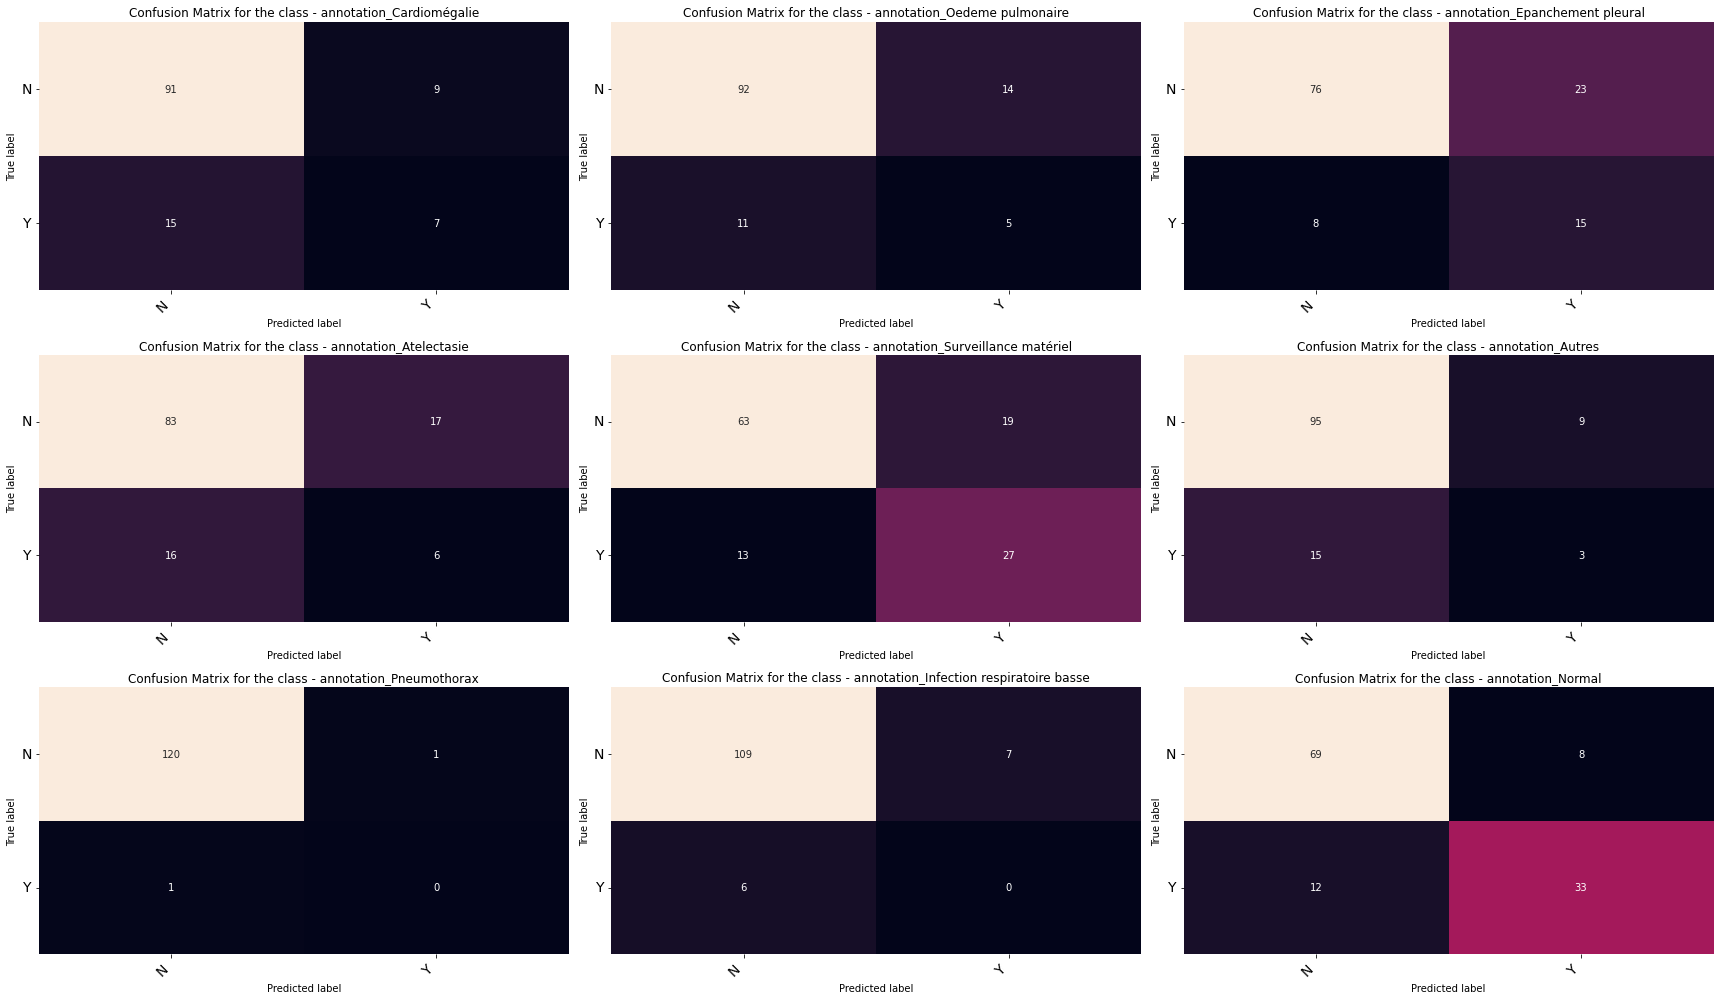

In [269]:
fig, ax = plt.subplots(3, 3, figsize=(24, 14))

for axes, cfs_matrix, label in zip(ax.flatten(), y_hats_cm, labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])

fig.tight_layout()
plt.show()

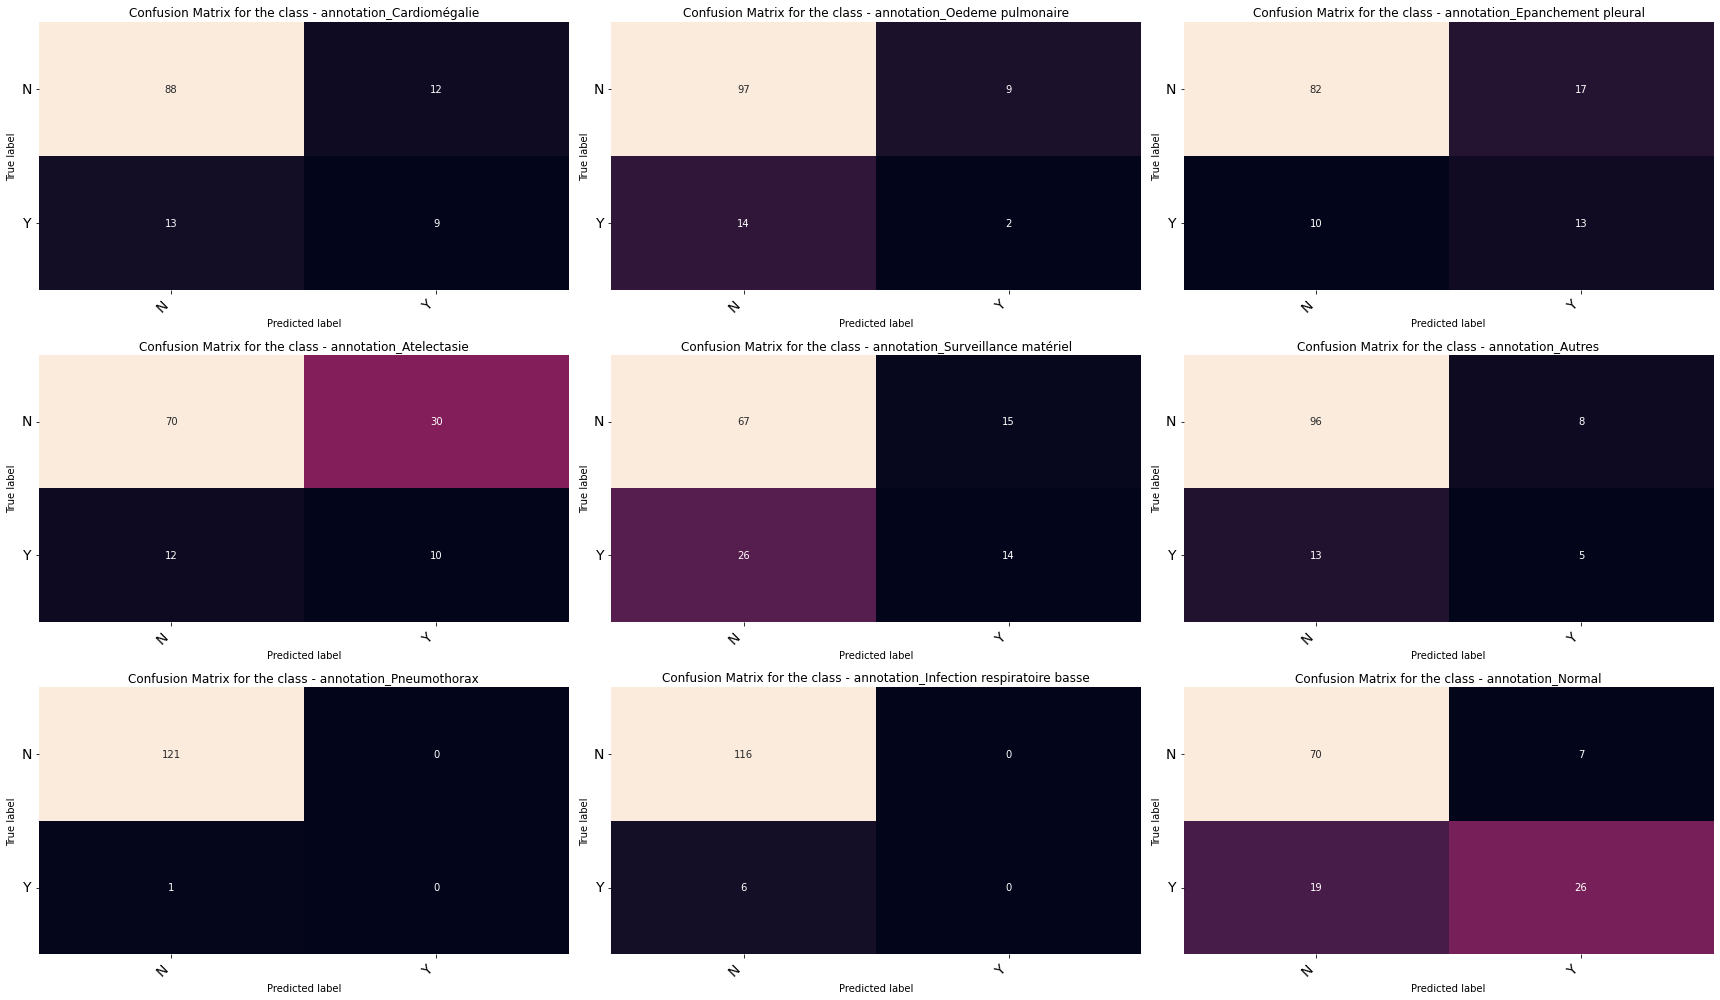

In [270]:
fig, ax = plt.subplots(3, 3, figsize=(24, 14))

for axes, cfs_matrix, label in zip(ax.flatten(), y_hats_ae1_cm, labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])

fig.tight_layout()
plt.show()

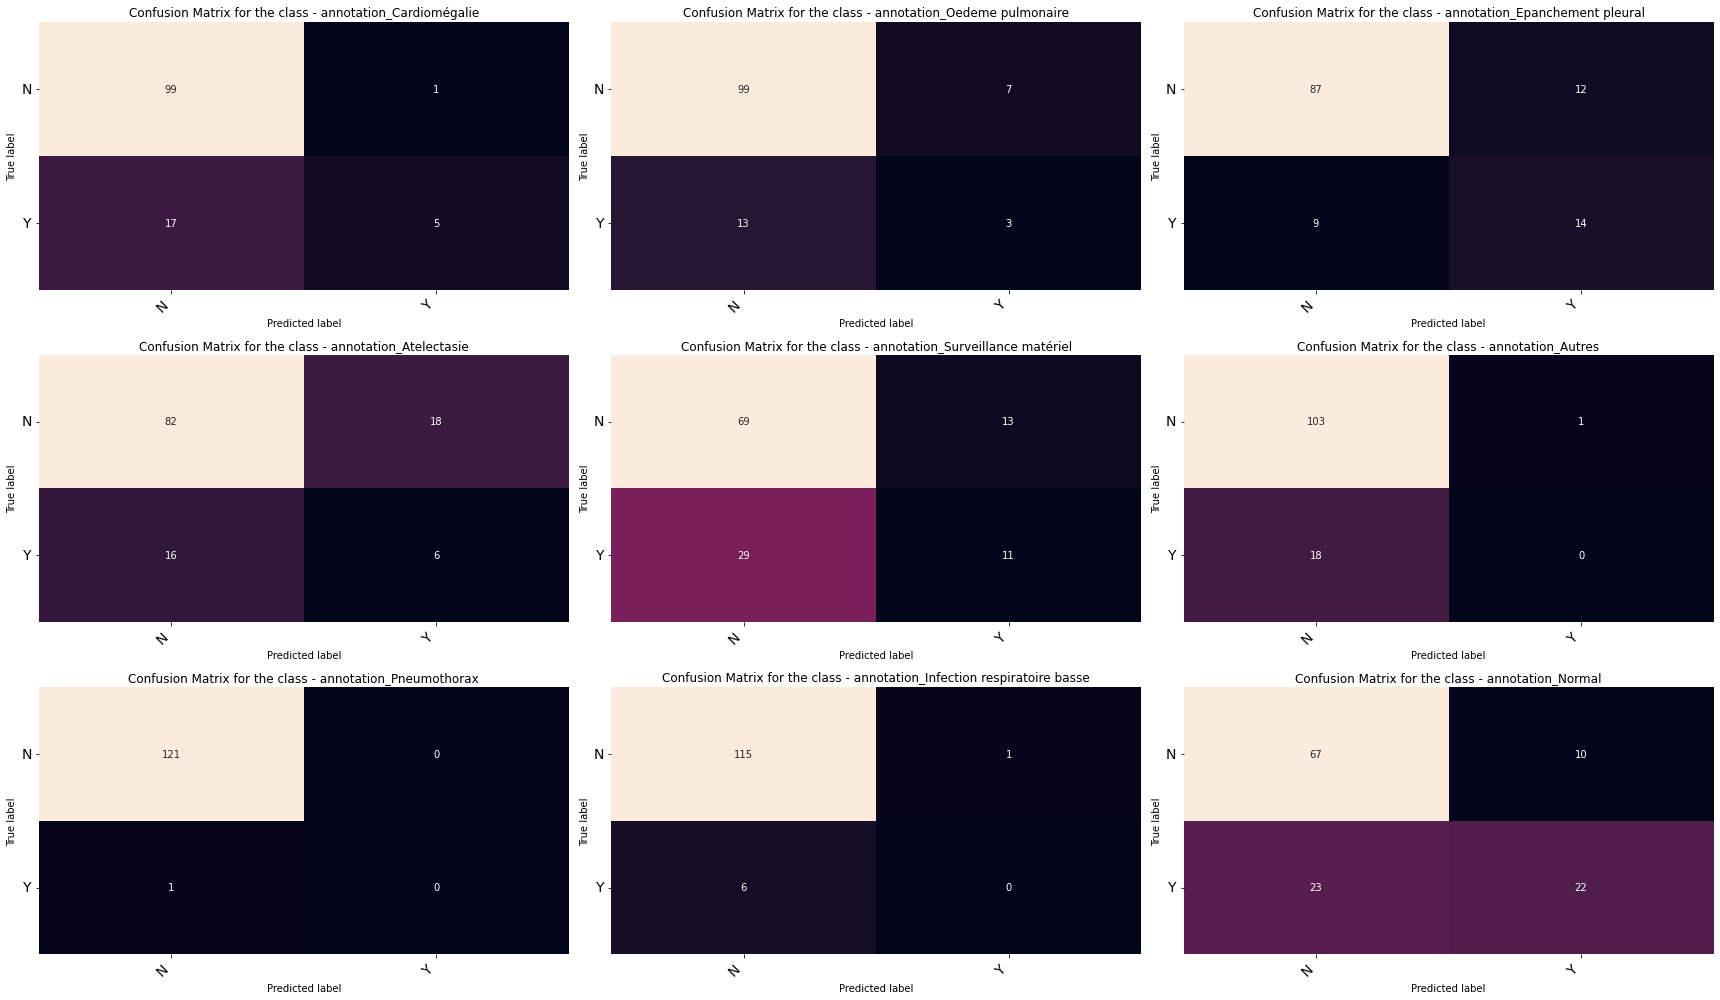

In [271]:
fig, ax = plt.subplots(3, 3, figsize=(24, 14))

for axes, cfs_matrix, label in zip(ax.flatten(), y_hats_ae2_cm, labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])

fig.tight_layout()
plt.show()

## Training CLASS_CXR_AE_

## Training CLASS_CXR_AE_2

# Benchmark and comparison

# OLD

In [ ]:
from torch.utils.data import DataLoader
from utils.dataset import imageDataset
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
X, y, X_annotated, y_annotated = get_data("./data", annotations_path="./data/annotations_08032021.zip", split_annotation=True)

# Getting documents embeddings

In [ ]:
from utils.text_processing.bert import BertEmbedder
bert_model = BertEmbedder(batch_size=10)

In [ ]:
y_embeddings = bert_model.transform(y["report_findings"].fillna("").astype("str").values)
#y_embeddings = y_embeddings.cpu().numpy()

In [ ]:
y_annotated_embeddings = bert_model.transform(y_annotated["report_findings"].fillna("").astype("str").values)
y_annotated_embeddings = y_annotated_embeddings.cpu().numpy()

y_annotated_impression_embeddings = bert_model.transform(y_annotated["report_impression"].fillna("").astype("str").values)
y_annotated_impression_embeddings = y_annotated_impression_embeddings.cpu().numpy()

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
tsne_model = TSNE(n_components=2, perplexity=30)
y_annotated_embeddings_2D = tsne_model.fit_transform(y_annotated_embeddings)
y_annotated_impressions_2D = tsne_model.fit_transform(y_annotated_impression_embeddings)

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
y_annotated

In [ ]:
# No more profil please !

X1 = X[1][X[1]["ViewPosition"].isin(["AP", "PA"])].reset_index(drop=True)
uids = X1["uid"].values.tolist()
X0 = imageDataset(dict([(x,y) for x,y in X[0].image_paths.items() if x in uids]))
labels = y[y["uid"].isin(uids)].reset_index(drop=True)

In [ ]:
from torch.nn.utils.rnn import pad_sequence
import torch

In [ ]:
y_embeddings = bert_model.transform(y["report_findings"].fillna("").astype("str").values)

In [ ]:
# Splitting train and test
X0 = X[0]
X0_train, X0_test = X0.split(p=0.7, random_seed=42)

train_id = X0_train.image_list
test_id = X0_test.image_list

X1 = X[1]
X1_train = X1.set_index("uid").loc[train_id,:].reset_index()
X1_test = X1.set_index("uid").loc[test_id,:].reset_index()

y_train = y.set_index("uid").loc[train_id,:].reset_index(drop=True)
y_test = y.set_index("uid").loc[test_id,:].reset_index(drop=True)

y_train_finding_embeddings = np.stack(y_train["report_findings"].fillna("").astype("str").apply(lambda x: fasttext_model.get_sentence_vector(x)).values.tolist())
y_train_impression_embeddings = np.stack(y_train["report_impression"].fillna("").astype("str").apply(lambda x: fasttext_model.get_sentence_vector(x)).values.tolist())

In [ ]:
from torchvision.transforms import RandomResizedCrop, Resize, Normalize
import torch
import numpy as np

In [ ]:
def dataset_collater (x):
    
    size = 500
    resizer = Resize(size)
    randomcrop = RandomResizedCrop(size=(size,size))
    mean = np.array([0.485, 0.456, 0.406]).mean()
    std = np.array([0.229, 0.224, 0.225]).sum()/np.sqrt(3)
    normalizer = Normalize(mean=mean, std=std)
    
    # Applying randomCrop
    images_tensor = []

    for x_ in x:
        image_tensor = torch.tensor(x_, dtype=torch.float32).unsqueeze(dim=0)
        image_tensor = resizer(image_tensor)
        image_tensor = randomcrop(image_tensor)

        images_tensor.append(image_tensor)

    output = torch.stack(images_tensor)
    output = normalizer(output/255.)

    return output

In [ ]:
def dataset_collater_nocrop (x):
    
    size = 500
    resizer = Resize((size, size))
    randomcrop = RandomResizedCrop(size=(size,size))
    mean = np.array([0.485, 0.456, 0.406]).mean()
    std = np.array([0.229, 0.224, 0.225]).sum()/np.sqrt(3)
    normalizer = Normalize(mean=mean, std=std)
    
    # Applying randomCrop
    images_tensor = []

    for x_ in x:
        image_tensor = torch.tensor(x_, dtype=torch.float32).unsqueeze(dim=0)
        image_tensor = resizer(image_tensor)

        images_tensor.append(image_tensor)

    output = torch.stack(images_tensor)
    output = normalizer(output/255.)

    return output

In [ ]:
import torch
from torch import nn
from torch import optim
from torchvision.models import resnet50

In [ ]:
class autoEncoder (nn.Module):

    def __init__ (self):
        super().__init__()

        self.resnet = resnet50(pretrained=True)

        # Layer that duplicate the color layer (b&w to rgb)
        duplicate_color_layers = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=(1,1), padding="same")
        duplicate_color_layers.requires_grad_(False)
        duplicate_color_layers.load_state_dict({
            "weight":torch.ones(duplicate_color_layers.weight.shape, dtype=torch.float32),
            "bias":torch.zeros(duplicate_color_layers.bias.shape)
        })

        self.encoder = nn.Sequential(*[
            duplicate_color_layers,
            nn.Sequential(*list(self.resnet.children())[0:-2]).to("cpu"),
            nn.Conv2d(2048, 1024, (1,1)),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(1024, 1, (1,1))
        ])

        self.decoder = nn.Sequential(*[
            nn.Conv2d(1, 16, kernel_size=(3,3), padding="same"),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Upsample((48,48)),
            nn.Conv2d(16, 32, kernel_size=(3,3), padding="same"),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Upsample((100,100)),
            nn.Conv2d(32, 64, kernel_size=(3,3), padding="same"),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Upsample((250,250)),
            nn.Conv2d(64, 32, kernel_size=(3,3), padding="same"),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Upsample((500,500)),
            nn.Conv2d(32, 16, kernel_size=(3,3), padding="same"),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 1, kernel_size=(1,1), padding="same"),
        ])

        self.embeddings_decoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 512),
            nn.ReLU()
        )

        self.embeddings_findings = nn.Sequential(
            nn.Linear(512, 300),
            nn.Tanh()
        )


        self.embeddings_impressions = nn.Sequential(
            nn.Linear(512, 300),
            nn.Tanh()
        )

        self.loss = nn.MSELoss()
        self.loss_embeddings = nn.MSELoss()
        self.optim = optim.Adam(self.parameters(), lr=1e-4)

    def forward (self, x):
        y_encode = self.encoder(x)

        return y_encode

    def fullpass (self, x):

        y_encode = self(x)

        y_decode = self.decoder(y_encode)
        y_embeddings = self.embeddings_decoder(y_encode)
        y_findings = self.embeddings_findings(y_embeddings)
        y_impressions = self.embeddings_impressions(y_embeddings)

        return y_decode, y_findings, y_impressions

    def fit (self, x, y):

        self.train()
        self.optim.zero_grad()
        y_findings, y_impressions = y

        x_, y_findings_, y_impressions_ = self.fullpass(x)

        loss_reconstruction = self.loss(x_, x)
        loss_embeddings_findings, loss_embeddings_impressions = self.loss_embeddings(y_findings_, y_findings), self.loss_embeddings(y_impressions_, y_impressions)

        loss = loss_reconstruction + loss_embeddings_findings + loss_embeddings_impressions

        loss.backward()
        self.optim.step()
        
        loss, loss_reconstruction, loss_embeddings_findings, loss_embeddings_impressions = [x.detach().cpu().item()
            for x in [loss, loss_reconstruction, loss_embeddings_findings, loss_embeddings_impressions]
        ]

        return loss, loss_reconstruction, loss_embeddings_findings, loss_embeddings_impressions

In [ ]:
ae = autoEncoder()
ae = ae.to("cuda:0")
ae.load_state_dict(torch.load("./models/ae.model"))

In [ ]:
ae.optim = optim.Adam(ae.parameters(), lr=1e-6)

In [ ]:
dataloader = DataLoader(range(len(X0_train)), shuffle=True, batch_size=4, num_workers=2)

In [ ]:
losses = {
    "global":[],
    "reconstruction":[],
    "embeddings_findings":[],
    "embeddings_impressions":[]
}

n_epoch = 5
print_pass = 20

for i in range(n_epoch):
    j = 0
    if len(losses["global"]) > 0:
        loss_mean = dict([(key, np.array(value).mean())
            for key, value in losses.items()
        ])
        print(f"Epoch {i}, Losses : {loss_mean}")

        losses = dict([(key, [])
            for key in losses.keys()
        ])
    
    print(f"Epoch {i}")
    for idx in dataloader:
        x = dataset_collater(X0_train[idx])
        y_findings_embeddings = torch.tensor(y_train_finding_embeddings[idx], dtype=torch.float32)
        y_impressions_embedding = torch.tensor(y_train_impression_embeddings[idx], dtype=torch.float32)

        x = x.to("cuda:0")
        y_findings_embeddings = y_findings_embeddings.to("cuda:0")
        y_impressions_embedding = y_impressions_embedding.to("cuda:0")

        loss = ae.fit(x, (y_findings_embeddings, y_impressions_embedding))
        for key, value in zip(losses.keys(), loss):
            losses[key].append(value)

        j += 1

        if (j % print_pass) == 0:
            loss_mean = dict([(key, np.array(value).mean())
                for key, value in losses.items()
            ])

            print(f"Pass {j} - Loss so far : {loss_mean}")

In [ ]:
from matplotlib import pyplot  as plt

In [ ]:
i = 3

In [ ]:
plt.imshow(x[i, 0, :, :].cpu(), cmap="gray")

In [ ]:
with torch.no_grad():
    pred = ae.fullpass(x[i, :, :, :].unsqueeze(1))[0][0, 0, :, :].detach().cpu()
plt.imshow(pred, cmap="gray")

In [ ]:
with torch.no_grad():
    pred = ae(x[i, :, :, :].unsqueeze(1))[0, 0, :, :].detach().cpu()
plt.imshow(pred, cmap="gray")

In [ ]:
toto = torch.tensor(np.random.randn(
    100, 1, 16, 16
), dtype=torch.float32).to("cuda:0")

In [ ]:
torch.save(
    ae.state_dict(),
    "./models/ae.model"
)

# Getting data projection

In [ ]:
n_batch = 16
dataloader_project = DataLoader(range(len(X0_train)), shuffle=False, batch_size=n_batch, num_workers=4)

In [ ]:
projections = []
device="cuda:0"

for idx in dataloader_project:
    print(f"Processing {n_batch} images")
    with torch.no_grad():
        x = dataset_collater_nocrop(X0[idx])
        x = x.to(device)
        y = ae(x)
        y = y.cpu().detach()
        projections.append(y)

In [ ]:
projected_data = torch.concat(projections, axis=0).numpy()

In [ ]:
import pickle

In [ ]:
with open("./data/projected_data.pickle", "wb") as f:
    pickle.dump(projected_data, f)

# K Means

In [ ]:
import pickle

In [ ]:
with open("./data/projected_data.pickle", "rb") as f:
    projected_data = pickle.load(f)

In [ ]:
projected_data = projected_data.reshape(projected_data.shape[0], -1)

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA

In [ ]:
projected_test_data_lr = PCA(n_components=5).fit_transform(projected_data)

In [ ]:
km = KMeans(n_clusters=5)
#dbs = DBSCAN(metric="cosine", min_samples=5, eps=5e-3)
#clusters = dbs.fit_predict(projected_test_data_lr)
clusters = km.fit_predict(projected_data)
np.bincount(clusters+abs(clusters.min()))

In [ ]:
labels_cluster = y_train.copy()
labels_cluster["cluster"] = clusters

labels_cluster = labels_cluster[[
    "cluster",
    'Atelectasis', 'Cardiomegaly',
    'Consolidation', 'Edema', 'Enlarged Cardiomediastinum', 'Fracture',
    'Lung Lesion', 'Lung Opacity', 'No Finding', 'Pleural Effusion',
    'Pleural Other', 'Pneumonia', 'Pneumothorax', 'Support Devices'
]]

for x in labels_cluster.columns:
    labels_cluster.loc[labels_cluster[x] < 0, x] = 0

labels_cluster.groupby("cluster").mean().T.plot.bar(figsize=(20,5))

In [ ]:
figs, axs = plt.subplots(3,3, figsize=(40,30))
axs = axs.flatten()

start_id = 500
end_id = start_id+9

images = X0[start_id:end_id]
for (i, j) in zip(range(len(images)), range(start_id, end_id, 1)):
    axs[i].imshow(
        images[i],
        cmap="gray"
    )
    axs[i].set_title(clusters[j])

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
low_projection = TSNE(n_components=2, perplexity=30).fit_transform(projected_data)

In [ ]:
plt.figure(figsize=(20,20))
plt.scatter(
    low_projection[:, 0],
    low_projection[:, 1],
    c=clusters
)

## Labels

# Reading documents

In [ ]:
y_train_copy = y_train.copy()
y_train_copy["cluster"] = clusters

In [ ]:
import wordcloud

In [ ]:
y_train_copy

In [ ]:
wc = wordcloud.WordCloud().generate(
    " ".join(y_train_copy["report_impression"].fillna("").astype("str").values.tolist())
)

plt.imshow(wc)

## By cluster

In [ ]:
wc_cluster = {}

stopwords = set(wordcloud.STOPWORDS)
stopwords.add("left")
stopwords.add("right")
stopwords.add("final")
stopwords.add("report")
stopwords.add("unchanged")

for cluster in y_train_copy["cluster"].unique():
    wc = wordcloud.WordCloud(
        stopwords=stopwords,
        max_words=20, 
        relative_scaling=1
    ).generate(
        " ".join(
            y_train_copy.query(f"cluster == {cluster}")["report_impression"].fillna("").astype("str").values.tolist()
        )
    )
    wc_cluster[cluster] = wc

In [ ]:
plt.imshow(wc_cluster[0])
plt.title("Cluster 0")

In [ ]:
plt.imshow(wc_cluster[1])
plt.title("Cluster 1")

In [ ]:
plt.imshow(wc_cluster[2])
plt.title("Cluster 2")

In [ ]:
plt.imshow(wc_cluster[3])
plt.title("Cluster 3")

In [ ]:
plt.imshow(wc_cluster[4])
plt.title("Cluster 4")

In [ ]:
plt.imshow(wc_cluster[5])
plt.title("Cluster 5")

In [ ]:
plt.imshow(wc_cluster[6])
plt.title("Cluster 6")

In [ ]:
i = 7
plt.imshow(wc_cluster[i])
plt.title(f"Cluster {i}")

In [ ]:
i = 8
plt.imshow(wc_cluster[i])
plt.title(f"Cluster {i}")

In [ ]:
i = 9
plt.imshow(wc_cluster[i])
plt.title(f"Cluster {i}")

In [ ]:
i = 10
plt.imshow(wc_cluster[i])
plt.title(f"Cluster {i}")

In [ ]:
i = 11
plt.imshow(wc_cluster[i])
plt.title(f"Cluster {i}")

In [ ]:
i = 12
plt.imshow(wc_cluster[i])
plt.title(f"Cluster {i}")

In [ ]:
i = 13
plt.imshow(wc_cluster[i])
plt.title(f"Cluster {i}")

In [ ]:
i = 14
plt.imshow(wc_cluster[i])
plt.title(f"Cluster {i}")

In [ ]:
i = 15

plt.imshow(wc_cluster[i])
plt.title(f"Cluster {i}")

In [ ]:
i = 16
plt.imshow(wc_cluster[i])
plt.title(f"Cluster {i}")

In [ ]:
i = 17
plt.imshow(wc_cluster[i])
plt.title(f"Cluster {i}")

In [ ]:
i = 18
plt.imshow(wc_cluster[i])
plt.title(f"Cluster {i}")

In [ ]:
i = 19
plt.imshow(wc_cluster[i])
plt.title(f"Cluster {i}")